In [ ]:
!mkdir Data

mkdir: cannot create directory ‘Data’: File exists


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os   
import pandas as pd
from typing import List, Dict, Tuple
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from scipy import optimize
np.random.seed(42)

In [ ]:
class LoadData():
  def __init__(self, mode : bool = False):
    self.mode = mode
    self.file_name = "premier_league_matches.txt"
    self.folder_name = "Data"

  def get_data_for_conversion(self, data : pd.core.frame.DataFrame, column : str) -> List[str]:
    items = []
    for item in data[column]:
      if item not in items:
        items.append(item)
    return items

  def feature_engineering(self, data : pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    data = self.rename_data_columns(data)
    data = self.update_data_columns(data)  
    data = self.remove_data_columns(data)
    return data
  
  def rename_data_columns(self, data : pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    data.rename(columns={"venue":"game_played"}, inplace=True)
    data.rename(columns={"sh":"overall_shots"}, inplace=True)
    data.rename(columns={"sot":"shots_of_target"}, inplace=True)
    data.rename(columns={"fk":"free_kicks"}, inplace=True)
    data.rename(columns={"pk":"penalties"}, inplace=True)
    data.rename(columns={"gf":"goals_for"}, inplace=True)
    data.rename(columns={"ga":"goals_against"}, inplace=True)
    data.rename(columns={"xg":"expected_goals"}, inplace=True)
    data.rename(columns={"xga":"expected_goals_against"}, inplace=True)
    data.rename(columns={"poss":"possession"}, inplace=True)
    return data
  
  def update_data_columns(self, data : pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    convertor_to_integer_opponents = {opponent : index for index, opponent in enumerate(self.get_data_for_conversion(data, "opponent"))}
    convertor_to_integer_teams = {opponent : index for index, opponent in enumerate(self.get_data_for_conversion(data, "team"))}
    data["date"] = data["date"].apply(pd.to_datetime)
    data["day_game_played"] = data["date"].dt.dayofweek
    data["time"] = pd.DataFrame([time.split(":")[0] for time in data["time"]]).astype("float64")
    data["round"] = pd.DataFrame([round.split(" ")[1] for round in data["round"]]).astype("float64")
    data["game_played"] = pd.DataFrame([0 if game_played == "Home" else 1 for game_played in data["game_played"]]).astype("float64")
    data["opponent"] = pd.DataFrame([convertor_to_integer_opponents[opponent] for opponent in data["opponent"]]).astype("float64")
    data["season"] = pd.DataFrame([1 if season == 2022 else 0 for season in data["season"]]).astype("float64")
    data["team"] = pd.DataFrame([convertor_to_integer_teams[team] for team in data["team"]]).astype("float64")
    data["day_game_played"] = pd.DataFrame([day_game_played for day_game_played in data["day_game_played"]]).astype("float64")
    data["result"] = pd.DataFrame([0 if result == "L" else (1 if result == "D" else 2) for result in data["result"]]).astype("float64")
    return data

  def remove_data_columns(self, data : pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    data.drop(["Unnamed: 0"], axis=1, inplace=True)
    data.drop(["day"], axis=1, inplace=True)
    data.drop(["date"], axis=1, inplace=True)
    data.drop(["comp"], axis=1, inplace=True) 
    data.drop(["attendance"], axis=1, inplace=True)
    data.drop(["captain"], axis=1, inplace=True)
    data.drop(["formation"], axis=1, inplace=True)
    data.drop(["referee"], axis=1, inplace=True)
    data.drop(["match report"], axis=1, inplace=True)
    data.drop(["notes"], axis=1, inplace=True)
    data.drop(["pkatt"], axis=1, inplace=True)
    data.drop(["dist"], axis=1, inplace=True)

    if self.mode:
      data.drop(["day_game_played"], axis=1, inplace=True)
      data.drop(["round"], axis=1, inplace=True)
      data.drop(["season"], axis=1, inplace=True)
      data.drop(["time"], axis=1, inplace=True)
      data.drop(["game_played"], axis=1, inplace=True)
      data.drop(["penalties"], axis=1, inplace=True)
    return data

  def visualize_data(self, data : pd.core.frame.DataFrame, name_x1 : str, name_x2 : str, color : str) -> None:
    x1, x2 = data[name_x1], data[name_x2]
    plt.scatter(x1, x2, c=color)
    plt.legend([name_x1, name_x2], loc ="upper right")
    plt.show();

  def get_path_of_dataset(self) -> str:
    return os.path.join(self.folder_name, self.file_name)  

  def read_dataset(self) -> pd.core.frame.DataFrame:
    return pd.read_csv(self.get_path_of_dataset())

In [ ]:
class DataNormalization():
  def __init__(self, data : pd.core.frame.DataFrame):
    self.data = data
  
  def normalize_data(self) -> pd.core.frame.DataFrame: 
    for column in self.data.columns:
      self.data[column] = pd.DataFrame(self.min_max_scaler(self.data[column])).astype("float64")
    return self.data
  
  def standardize_data(self) -> pd.core.frame.DataFrame:
    scaler = StandardScaler()
    scaler.fit(self.data)
    return scaler.transform(self.data)

  def min_max_scaler(self, column_data : pd.core.series.Series) -> list:
    return [round((data - min(column_data)) / (max(column_data) - min(column_data)), 2) for data in column_data]

In [ ]:
class SeparateData():
  def __init__(self, data : pd.core.frame.DataFrame):
    self.data = data
    self.visualize = True
    self.visualize_choice = input("[a - look at one random feature data distribution| b - look at all the features data distribution] = ")

  def get_features_labels(self) -> Tuple[np.ndarray]:
    features = np.zeros((self.data.shape[0], self.data.shape[1]-1))
    count = 0
    for (i, column) in enumerate(self.data.columns):
      flag = False
      for j in range(self.data.shape[0]):
        if column == "result": 
          flag = True
          break
        features[j][count] = self.data[column][j]
      if flag: 
        count -= 1
      count += 1
    labels = np.array([result for result in self.data["result"]])

    if self.visualize:
      if self.visualize_choice == "a":
        feature_number = random.randint(0, features.shape[1]-1)
        self.visualize_data(features[:, feature_number].flatten(), labels.flatten())
      elif self.visualize_choice == "b":
        for i in range(len(self.data.columns)-1):
          self.visualize_data(features[:, i].flatten(), labels.flatten())

    return features, labels
  
  def visualize_data(self, x : np.ndarray, y : np.ndarray) -> None:
    plt.plot(x, y, "r")
    plt.show()

  def check_shapes(self, features : np.ndarray, labels : np.ndarray) -> str:
    return f"Shape of data frame = {str(self.data.shape)},\nShape of features = {str(features.shape)} and labels = {str(labels.shape)}"
  
  def check_values(self, features : np.ndarray, labels : np.ndarray) -> str:
    return f"value features = {str(features[:5])}\nvalue labels = {str(labels[:5])}"


In [ ]:
class SplitData():
  def __init__(self, features : np.ndarray, labels : np.ndarray):
    self.features = features
    self.labels = labels
    self.labels = self.labels.reshape(-1, 1) 
    self.training_procent = 0.8
    self.testing_procent = 1 - self.training_procent
  
  def split_into_training_and_tesing_sets(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    return train_test_split(self.features, self.labels, test_size=0.2, random_state=42)
    # return self.features[:round(self.features.shape[0]*self.training_procent), :], self.features[:round(self.features.shape[0]*self.testing_procent), :], \
    # self.labels[:round(self.labels.shape[0]*self.training_procent), :], self.labels[:round(labels.shape[0]*self.testing_procent), :]

In [ ]:
class KNN():
  def __init__(self, X_train : np.ndarray, y_train : np.ndarray, X_test : np.ndarray, y_test : np.ndarray, k_neighbors : int = 3):
    self.X_train = np.concatenate((X_train, X_test), axis=0)
    self.y_train = np.concatenate((y_train, y_test), axis=0)
    self.k_neighbors = k_neighbors
  
  def predict_classifier(self) -> np.ndarray:
    label_of_neighbors = self.get_neighbors()
    y_preds = np.zeros(self.y_train.shape[0])
    for i, neighbors_index in enumerate(label_of_neighbors):
      lose, draw, win = 0, 0, 0
      for neighbor_index in neighbors_index:
        if self.y_train[neighbor_index] == 0: lose += 1
        elif self.y_train[neighbor_index] == 1: draw += 1
        elif self.y_train[neighbor_index] == 2: win += 1
      possible_outcome = [[lose, 0], [draw, 1], [win, 2]] 
      possible_outcome.sort(key=lambda l : l[0], reverse=True)
      max_occurence = possible_outcome[0][-1]
      y_preds[i] = max_occurence
    return np.array(y_preds)
  
  def get_accuracy(self) -> float:
    y_preds = self.predict_classifier()
    correct = 0
    for pred, truth in zip(y_preds, self.y_train):
      if int(pred) == int(truth): correct += 1
    return float((correct/self.y_train.shape[0])*100)
      
  def get_neighbors(self) -> List[list]:
    label_neighbors = []
    for num_sample, sample in enumerate(self.X_train):
      distance = self.calculate_euclidean_distance(sample, num_sample)
      distance = [(index,d) for index, d in enumerate(distance)]
      distance.sort(key=lambda l : l[1])
      _neighbors = []
      for i in range(self.k_neighbors):
        _neighbors.append(distance[i][0])
      label_neighbors.append(_neighbors)
    return label_neighbors

  def calculate_minkowski_distance(self, sample : np.ndarray, num_sample : int, p : int) -> List[np.ndarray]:
    return [np.power(np.sum(np.power(np.abs(sample - x), p)), 1/p) for i, x in enumerate(self.X_train) if num_sample != i]

  def calculate_euclidean_distance(self, sample : np.ndarray, num_sample : int) -> List[np.ndarray]:
    return [np.sum(np.sqrt((sample-x)**2)) for i, x in enumerate(self.X_train) if num_sample != i] 

In [ ]:
class NaiveBayes():
    def __init__(self):
        self.class_mean = None
        self.class_std = None
        self.priors = None
        self.classes = None
        
    def fit(self, X_train : np.ndarray, y_train : np.ndarray) -> None:
        n = X_train.shape[0]
        d = X_train.shape[1]

        unique_classes, class_counts = np.unique(y_train, return_counts=True)
        self.classes = unique_classes
        self.classes = [int(_class) for _class in self.classes]
        self.priors = class_counts / n

        self.class_mean = np.zeros((len(self.classes) + 1, d))
        self.class_std = np.zeros((len(self.classes) + 1, d))
        for i, c in enumerate(self.classes):
           indices = np.squeeze(np.argwhere(y_train == c))
           X_c = X_train[indices]
           self.class_mean[c: i+2, :] = np.mean(X_c, axis=0)
           self.class_std[c: i+2, :] = np.std(X_c, axis=0)

    def predict(self, X_test : np.ndarray):
        m = X_test.shape[0]
        likelihood = np.zeros((m, len(self.classes), X_test.shape[1]))
        for c in self.classes:
            likelihood[:, c, :] = (1 / (np.sqrt(2 * np.pi) * self.class_std[c, :])) * np.exp(-0.5 * (X_test - self.class_mean[c, :]) ** 2 / self.class_std[c, :] ** 2)
        posteriors = np.zeros((m, len(self.classes)))
        for c in self.classes:
            posteriors[:, c] = self.priors[c] * np.prod(likelihood[:, c, :], axis=1)
        posteriors /= np.sum(posteriors, axis=1, keepdims=True)
        y_pred = np.argmax(posteriors, axis=1)
        return y_pred
    
    def accuracy(self, y_truth : np.ndarray, y_preds : np.ndarray):
        correct = 0
        for pred, truth in zip(y_preds, y_truth):
          if int(pred) == int(truth): correct += 1
        return float((correct/y_truth.shape[0])*100)

In [ ]:
class MulticlassClassification():
  def __init__(self):
    self.weights = None
    self.bias = None    
    self.features = None
    self.n_classes = None
    self.samples = None
    self.mode = "manual"
    self.param_init = "zeros"
  
  def get_maximum_prediction(self, prediction : np.ndarray) -> np.ndarray:
    outList = []
    for p in prediction:
      max, maxIndex = p[0], 0
      for index in range(1, len(p)):
        if p[index] > max:
          max, maxIndex = p[index], index
      outList.append(maxIndex)
    return np.array(outList)
  
  def accuracy(self, y_truth : np.ndarray, predictions : np.ndarray) -> float:
    correct = 0
    for pred, truth in zip(predictions, y_truth):
      if int(pred) == int(truth): correct += 1
    return float((correct/y_truth.shape[0])*100)

  def one_vs_all_prediction(self,  X : np.ndarray, all_theta : np.ndarray) -> np.ndarray:
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    all_theta = all_theta.T
    p = self.sigmoid(np.dot(X, all_theta)) 
    return self.get_maximum_prediction(p)

  def callback(self, theta : np.ndarray, X_train : np.ndarray, y_train : np.ndarray, lambda_ : int, J_history : list) -> list:
    J_history.append(self.cost_function(theta, X_train, y_train, lambda_)[0])
    return J_history

  def plot_cost(self, J_history : np.ndarray) -> None:
    plt.plot(J_history)
    plt.xlabel("Number of iterations")
    plt.ylabel("Cost function")
    plt.show()

  def gradient_descent(self, X_train : np.ndarray, y_train : np.ndarray, learning_rate : float = 0.1, num_iterations : int = 5000):
    self.samples = X_train.shape[0]
    self.features = X_train.shape[1]
    self.n_classes = len(np.unique(y_train))  
    lambda_ = 0.01
    X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
    all_theta = np.zeros((self.n_classes, self.features+1))
    J_history = []

    if self.mode == "optimize":
      for c in range(self.n_classes):
        if self.param_init == "random": initial_theta = np.random.uniform(-1, 1, size=(self.features+1))
        elif self.param_init == "zeros": initial_theta = np.zeros(self.features + 1)
        y_train_per_class = y_train == c
        y_train_per_class = np.array([1 if y == True else 0 for y in y_train_per_class]).reshape(-1, 1)
        res = optimize.minimize(self.cost_function, 
                                  initial_theta, 
                                  (X_train, y_train_per_class, lambda_), 
                                  jac=True, 
                                  method='TNC',
                                  options={"maxiter" : num_iterations},
                                  callback=lambda x: self.callback(x, X_train, y_train, lambda_, J_history)) 
        all_theta[c, :] = res.x 
      return all_theta, J_history

    elif self.mode == "manual":
      for c in range(self.n_classes):
        if self.param_init == "random": theta = np.random.uniform(-1, 1, size=(self.features+1))
        elif self.param_init == "zeros": theta = np.zeros(self.features + 1)
        y_train_per_class = y_train == c
        y_train_per_class = np.array([1 if y == True else 0 for y in y_train_per_class]).reshape(-1, 1)
        for epoch in range(num_iterations+1):
            cost, grad = self.cost_function(theta, X_train, y_train_per_class, lambda_)
            theta -= learning_rate * grad
            if epoch < self.samples:
              J_history.append(cost)
            if epoch % 50 == 0:
              print(f"epoch = {epoch}, cost = {cost}")
        all_theta[c, :] = theta
      return all_theta, J_history

    return all_theta, J_history # will never reach here
  
  # compute the cross entropy cost function with regularization and the gradients
  def cost_function(self, theta : np.ndarray, X_train : np.ndarray, y_train : np.ndarray, lambda_ : float) -> float: 
    cross_entropy = (1/self.samples) * np.sum(-(y_train[index])*np.log(self.sigmoid(np.dot(X_train[index], theta))) - \
    (1-y_train[index])*np.log(1-self.sigmoid(np.dot(X_train[index], theta))) for index in range(self.samples)) + \
    (lambda_/(2*self.samples)) * (np.sum(0 if j == 0 else np.square(theta[j]) for j in range(theta.shape[0])))

    gradients = (1/self.samples)*np.dot(X_train.T, (self.sigmoid(np.dot(X_train, theta)) - y_train[:, 0])) + \
    (lambda_/self.samples)*np.array([float(0) if index == 0 else float(t) for (index, t) in enumerate(theta)])
    return cross_entropy, gradients
  
  def sigmoid(self, x : np.ndarray) -> float:
    return 1 / (1 + np.exp(-x))

Index(['result', 'goals_for', 'goals_against', 'opponent', 'expected_goals',
       'expected_goals_against', 'possession', 'overall_shots',
       'shots_of_target', 'free_kicks', 'team'],
      dtype='object')
            result    goals_for  goals_against     opponent  expected_goals  \
count  1389.000000  1389.000000    1389.000000  1389.000000     1389.000000   
mean      0.492081     0.147113       0.152124     0.469323        0.283621   
std       0.439751     0.140863       0.142763     0.283357        0.166625   
min       0.000000     0.000000       0.000000     0.000000        0.000000   
25%       0.000000     0.000000       0.000000     0.230000        0.150000   
50%       0.500000     0.110000       0.110000     0.450000        0.260000   
75%       1.000000     0.220000       0.220000     0.730000        0.390000   
max       1.000000     1.000000       1.000000     1.000000        1.000000   

       expected_goals_against   possession  overall_shots  shots_of_target  

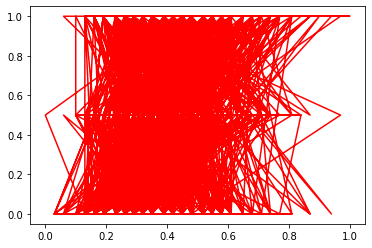

(1389, 10)
(1389,)
[[0.   0.11 0.   ... 0.27 0.25 0.  ]
 [0.56 0.   0.05 ... 0.27 0.25 0.  ]
 [0.56 0.   0.09 ... 0.67 0.   0.  ]
 ...
 [0.11 0.   0.5  ... 0.2  0.   1.  ]
 [0.   0.11 0.77 ... 0.07 0.25 1.  ]
 [0.11 0.   0.32 ... 0.2  0.   1.  ]]
[0. 1. 1. ... 1. 0. 1.]
Shape of data frame = (1389, 11),
Shape of features = (1389, 10) and labels = (1389,)
value features = [[0.   0.11 0.   0.41 0.26 0.72 0.58 0.27 0.25 0.  ]
 [0.56 0.   0.05 0.59 0.02 0.77 0.52 0.27 0.25 0.  ]
 [0.56 0.   0.09 0.83 0.02 0.97 0.81 0.67 0.   0.  ]
 [0.11 0.   0.14 0.63 0.16 0.67 0.81 0.53 0.   0.  ]
 [0.   0.   0.18 0.24 0.08 0.7  0.52 0.07 0.25 0.  ]]
value labels = [0.  1.  1.  1.  0.5]


In [ ]:
if __name__ == "__main__":
  debug_mode = True
  choice = "normalize"
  load_data = LoadData(True)
  data = load_data.read_dataset()
  data = load_data.feature_engineering(data) 
  # load_data.visualize_data(data, "time", "result", "red")
  
  column_names = list(data.columns)
  normalization = DataNormalization(data) 
  if choice == "standardize" : data = normalization.standardize_data(); data.columns = column_names
  elif choice == "normalize" : data = normalization.normalize_data()

  if debug_mode:
    print(data.columns)
    print(data.describe())
  
  separate = SeparateData(data)
  features, labels = separate.get_features_labels()
  print(features.shape)
  print(labels.shape)
  print(features)
  print(labels)
  if debug_mode:
    print(separate.check_shapes(features, labels))
    print(separate.check_values(features, labels))
    
  split_data = SplitData(features, labels)
  X_train, X_test, y_train, y_test = split_data.split_into_training_and_tesing_sets()

In [ ]:
  print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
  for i, y in enumerate(y_train): y_train[i] *= 2
  for i, y in enumerate(y_test): y_test[i] *= 2

(1111, 10) (1111, 1) (278, 10) (278, 1)


In [ ]:
def get_maximum_neighbor_accuracy() -> str:
  max_accuracy = 0
  index_accuracy = -1
  for i in range(3, 100):
    k_nearest_neighbors = KNN(X_train, y_train, X_test, y_test, k_neighbors=i)
    accuracy = k_nearest_neighbors.get_accuracy()
    if accuracy > max_accuracy: 
      index_accuracy = i
      max_accuracy = accuracy
  return f"Accuracy of KNN = {max_accuracy} % with neighbors = {index_accuracy}"

In [ ]:
k_nearest_neighbors = KNN(X_train, y_train, X_test, y_test, k_neighbors=25)
accuracy = k_nearest_neighbors.get_accuracy()
print(f"Accuracy of KNN testing set = {accuracy} % - our implementation")

print("__________________________________")

k_nearest_neighbors_sklearn = neighbors.KNeighborsClassifier(n_neighbors=25)
k_nearest_neighbors_sklearn.fit(np.concatenate((X_train, X_test), axis=0), np.concatenate((y_train, y_test), axis=0).ravel())
y_pred_train = k_nearest_neighbors_sklearn.predict(np.concatenate((X_train, X_test), axis=0))
correct = 0
for pred, truth in zip(y_pred_train, y_train): 
  if int(pred) == int(truth): correct += 1
print(f"Accuracy of KNN testing set = {int((correct/y_train.shape[0])*100)} % - sklearn implementation")

Accuracy of KNN testing set = 69.11447084233261 % - our implementation
__________________________________
Accuracy of KNN testing set = 79 % - sklearn implementation


In [ ]:
naive_bayes = NaiveBayes()
naive_bayes.fit(X_train, y_train)
y_pred = naive_bayes.predict(X_test)
naive_bayes.accuracy(y_test, y_pred)
print(f"Accuracy of Naive Bayes testing set = {naive_bayes.accuracy(y_test, y_pred)} % - our implementation")

print("__________________________________")

naive_bayes_sklearn = GaussianNB()
naive_bayes_sklearn.fit(X_train, y_train)
y_pred = naive_bayes.predict(X_test)
correct = 0
for pred, truth in zip(y_pred, y_test): 
  if int(pred) == int(truth): correct += 1
print(f"Accuracy of Naive Bayes testing set = {int((correct/y_test.shape[0])*100)} % - sklearn implementation")

Accuracy of Naive Bayes testing set = 69.42446043165468 % - our implementation
__________________________________
Accuracy of Naive Bayes testing set = 69 % - sklearn implementation


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


epoch = 0, cost = [0.69314718]


<ipython-input-24-240bc1bbf10e>:88: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  cross_entropy = (1/self.samples) * np.sum(-(y_train[index])*np.log(self.sigmoid(np.dot(X_train[index], theta))) - \
<ipython-input-24-240bc1bbf10e>:90: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  (lambda_/(2*self.samples)) * (np.sum(0 if j == 0 else np.square(theta[j]) for j in range(theta.shape[0])))


epoch = 50, cost = [0.63511368]
epoch = 100, cost = [0.60798236]
epoch = 150, cost = [0.5854136]
epoch = 200, cost = [0.56625378]
epoch = 250, cost = [0.5497333]
epoch = 300, cost = [0.53528211]
epoch = 350, cost = [0.52247613]
epoch = 400, cost = [0.51099726]
epoch = 450, cost = [0.50060431]
epoch = 500, cost = [0.49111223]
epoch = 550, cost = [0.48237725]
epoch = 600, cost = [0.47428631]
epoch = 650, cost = [0.46674937]
epoch = 700, cost = [0.45969393]
epoch = 750, cost = [0.45306088]
epoch = 800, cost = [0.44680156]
epoch = 850, cost = [0.44087547]
epoch = 900, cost = [0.43524857]
epoch = 950, cost = [0.42989202]
epoch = 1000, cost = [0.42478115]
epoch = 1050, cost = [0.41989466]
epoch = 1100, cost = [0.41521408]
epoch = 1150, cost = [0.41072325]
epoch = 1200, cost = [0.40640793]
epoch = 1250, cost = [0.40225552]
epoch = 1300, cost = [0.39825478]
epoch = 1350, cost = [0.39439565]
epoch = 1400, cost = [0.39066909]
epoch = 1450, cost = [0.38706693]
epoch = 1500, cost = [0.38358174]
ep

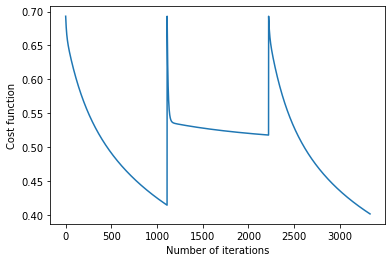

Accuracy of Logistic Classification Multiclass training set = 80.64806480648065 % - our implementation
Accuracy of Logistic Classification Multiclass testing set = 80.93525179856115 % - our implementation
__________________________________
Accuracy of Logisitic classification Multiclass training set = 83 % - sklearn implementation
Accuracy of Logisitic classification Multiclass testing set = 84 % - sklearn implementation


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
multiclass_classification = MulticlassClassification()
optimized_theta, J_history = multiclass_classification.gradient_descent(X_train, y_train)
multiclass_classification.plot_cost(J_history)
predictions_training = multiclass_classification.one_vs_all_prediction(X_train, optimized_theta)
predictions_testing = multiclass_classification.one_vs_all_prediction(X_test, optimized_theta)
print(f"Accuracy of Logistic Classification Multiclass training set = {multiclass_classification.accuracy(y_train, predictions_training)} % - our implementation")
print(f"Accuracy of Logistic Classification Multiclass testing set = {multiclass_classification.accuracy(y_test, predictions_testing)} % - our implementation")

print("__________________________________")

multiclass_classification_sklearn = LogisticRegression(multi_class="ovr")
multiclass_classification_sklearn.fit(X_train, y_train)
y_pred_train = multiclass_classification_sklearn.predict(X_train)
y_pred_test = multiclass_classification_sklearn.predict(X_test)

correct = 0
for pred, truth in zip(y_pred_train, y_train): 
  if int(pred) == int(truth): correct += 1
print(f"Accuracy of Logisitic classification Multiclass training set = {int((correct/y_train.shape[0])*100)} % - sklearn implementation")
correct = 0
for pred, truth in zip(y_pred_test, y_test): 
  if int(pred) == int(truth): correct += 1
print(f"Accuracy of Logisitic classification Multiclass testing set = {int((correct/y_test.shape[0])*100)} % - sklearn implementation")